<a href="https://colab.research.google.com/github/ju-ki/atma10/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText
!rm -rf fastText

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.23 MiB | 31.90 MiB/s, done.
Resolving deltas: 100% (2416/2416), done.


In [3]:
pip install category_encoders xfeat

In [4]:
import os 
import glob 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fasttext import load_model
sns.set()
CODE_PATH = "/content/drive/MyDrive/atmacup10/code/"
INPUT_PATH = "/content/drive/MyDrive/atmacup10/data/raw/"
OUTPT_PAHT = "/content/drive/MyDrive/atmacup10/data/submission/"

In [5]:
train = pd.read_csv(INPUT_PATH + "train.csv")
test = pd.read_csv(INPUT_PATH + "test.csv")

In [6]:
train.head(3)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2
2,0017be8caa87206532cb,4c406890d208fe01f8fb,Portret van een vrouw,"Portret van eenvrouw, zittend naast een tafel.","Portret van een vrouw, Tresling & Comp., 1860 ...",Tresling & Comp.,Tresling & Comp.,h 87mm × w 56mm,NaN,Portret van een vrouw,gift,2007-01-01T00:00:00,"Gift of M.M. Boom, Leiden",1860 - 1880,1860.0,19,1860.0,1880.0,5


In [7]:
def get_period_of_production(input_df):
  out_df = pd.DataFrame()
  out_df["period_of_production"] = input_df["dating_year_late"] - input_df["dating_year_early"]
  return out_df

In [8]:
model = load_model("/content/drive/MyDrive/atmacup10/data/external/lid.176.bin")

In [9]:
def get_label_lang(input_df, cols):
  out_df = pd.DataFrame()
  out_df["label_lang"] = input_df[cols].fillna("").map(lambda x: model.predict(x.replace("\n", ""))[0][0])
  return out_df.add_suffix(f"_{cols}")

In [10]:
train = pd.concat([train, get_label_lang(train, "title")], axis=1)
train = pd.concat([train, get_label_lang(train, "description")], axis=1)

test = pd.concat([test, get_label_lang(test, "title")], axis=1)
test = pd.concat([test, get_label_lang(test, "description")], axis=1)

In [11]:
def get_count(input_df, cols):
  out_df = pd.DataFrame()
  out_df["count"] = input_df[cols].apply(lambda x: len(x.split())).fillna(0)
  return out_df.add_suffix(f"_{cols}")

In [12]:
get_count(train, "title")

,count_title
0,4
1,3
2,4
3,4
4,4
...,...
12021,7
12022,10
12023,10
12024,6


In [13]:
train["acquisition_date"] = pd.to_datetime(train["acquisition_date"])

In [14]:
train["acquisition_date"].dt.year

0        1808.0
1        2000.0
2        2007.0
3        1881.0
4        1971.0
          ...  
12021    1994.0
12022    1881.0
12023    1887.0
12024    1881.0
12025    1941.0
Name: acquisition_date, Length: 12026, dtype: float64

In [15]:
def get_time_between_late_year_and_acqusition(input_df):
  input_df["acquisition_date"] = pd.to_datetime(input_df["acquisition_date"])
  input_df["year"] = input_df["acquisition_date"].dt.year.fillna(0)
  out_df = pd.DataFrame()
  out_df["period_of_acquisition_date"] = input_df["year"]- input_df["dating_year_late"].fillna(0).astype(float)
  return out_df

In [16]:
get_time_between_late_year_and_acqusition(train)

,period_of_acquisition_date
0,123.0
1,70.0
2,127.0
3,2.0
4,97.0
...,...
12021,74.0
12022,167.0
12023,109.0
12024,191.0


In [17]:
os.chdir("/content/drive/MyDrive/atmacup10/code/")
from feature_engine import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
class AbstractBaseBlock:
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()
    
class WrapperBlock(AbstractBaseBlock):
    def __init__(self, function):
        self.function = function
        
    def transform(self, input_df):
        return self.function(input_df)

In [19]:
from tqdm import tqdm

def get_function(block,is_train):
    s = mapping ={
        True:'fit',
        False:'transform'
    }.get(is_train)
    return getattr(block,s)

def to_feature(input_df,remain_df,blocks,is_train=False):
    out_df = remain_df
    
    for block in tqdm(blocks,total=len(blocks)):
        func = get_function(block,is_train)
        
        with timer(prefix='create' + str(block) + ' '):
            _df = func(input_df)
        
        assert len(_df) == len(input_df),func._name_
        out_df = pd.concat([out_df,_df],axis=1)
    return out_df

In [20]:
from time import time
from contextlib import contextmanager

@contextmanager
def timer(logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None):
  if prefix: format_str = str(prefix) + format_str
  if suffix: format_str = format_str + str(suffix)
  start = time()
  yield
  d = time() - start
  out_str = format_str.format(d)
  if logger:
    logger.info(out_str)
  else:
    print(out_str)

In [21]:
class CountEncodingBlock(AbstractBaseBlock):
    
    """
    CountEncodingを行うブロック
    """
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, input_df, y=None):
        self.encoder = ce.CountEncoder()
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df = self.encoder.fit_transform(input_df[self.cols]).add_prefix("CE_")
        return out_df

In [22]:
CountEncodingBlock("label_lang_title").fit(get_label_lang(train, "title"))

,CE_label_lang_title
0,2342
1,9090
2,9090
3,2342
4,9090
...,...
12021,9090
12022,9090
12023,9090
12024,9090


In [23]:
def max_min(x):
    return x.max() - x.min()

def q75_q25(x):
    return x.quantile(0.75) - x.quantile(0.25)

In [24]:
class AggregationBlock(AbstractBaseBlock):
    """
    集約変数を作成するブロック
    
    cols:
      group_key:元になる変数:age, country etc..
      group_values:集約を行う対象の変数:n_items etc..
      agg_methods:どのような方法で集約するか. デフォルトはmax, min, meanの三つ
    """
    def __init__(self, group_key, group_values, agg_methods=["max", "min", "mean"]):
        self.group_key = group_key
        self.group_values = group_values
        self.agg_methods = agg_methods
     
    def transform(self, input_df):
        self.agg_df, self.agg_col = xfeat.aggregation(input_df,
                                        agg_methods=self.agg_methods,
                                        group_key=self.group_key,
                                        group_values=self.group_values)
        
        out_df = pd.DataFrame()
        out_df = self.agg_df
        return out_df[self.agg_col]

In [25]:
AggregationBlock(group_key="label_lang_title", 
                                   group_values=["dating_period"],
                                   agg_methods=["max", "min", "std", "median", max_min, q75_q25]).transform(test)

,agg_max_dating_period_grpby_label_lang_title,agg_min_dating_period_grpby_label_lang_title,agg_std_dating_period_grpby_label_lang_title,agg_median_dating_period_grpby_label_lang_title,agg_<function max_min at 0x7f2ea424b5f0>_dating_period_grpby_label_lang_title,agg_<function q75_q25 at 0x7f2ea4309b00>_dating_period_grpby_label_lang_title
0,21,-2,1.313449,19.0,23,2.0
1,21,13,1.204547,17.0,8,2.0
2,21,-2,1.313449,19.0,23,2.0
3,21,-2,1.313449,19.0,23,2.0
4,21,-2,1.313449,19.0,23,2.0
...,...,...,...,...,...,...
12003,21,-2,1.313449,19.0,23,2.0
12004,21,-2,1.313449,19.0,23,2.0
12005,21,13,1.204547,17.0,8,2.0
12006,21,-2,1.313449,19.0,23,2.0


In [26]:
process_blocks = [
                 WrapperBlock(get_period_of_production),
                 WrapperBlock(get_time_between_late_year_and_acqusition),
                 CountEncodingBlock("label_lang_title"),
                 CountEncodingBlock("label_lang_description"),
                 CountEncodingBlock("acquisition_method"),
                 CountEncodingBlock("principal_maker"),
                 AggregationBlock(group_key="label_lang_title", 
                                   group_values=["dating_period"],
                                   agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="label_lang_description",
                                  group_values=["dating_period"],
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="acquisition_method",
                                  group_values=["dating_period"],
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="principal_maker",
                                  group_values=["dating_period"],
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
]

In [33]:
drop_columns = ["object_id", "art_series_id", "description", "long_title", "title", "principal_maker", "principal_or_first_maker",
                  "sub_title", "copyright_holder", "more_title", "acquisition_credit_line", "dating_presenting_date",
                  "dating_sorting_date", "acquisition_date", "acquisition_method", "label_lang_title", "label_lang_description"]
train_feat_df = to_feature(train,train.drop(columns=drop_columns, axis=1),process_blocks, is_train=True)

test_feat_df = to_feature(test,test.drop(columns=drop_columns, axis=1),process_blocks,is_train=False)

  0%|          | 0/10 [00:00<?, ?it/s]

create<__main__.WrapperBlock object at 0x7f2ea413ca50> 0.003[s]
create<__main__.WrapperBlock object at 0x7f2ea413ce10> 0.023[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413ce50> 0.009[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413ce90> 0.008[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413ced0> 0.008[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413cf10> 0.008[s]
create<__main__.AggregationBlock object at 0x7f2ea413cf50> 0.138[s]


 90%|█████████ | 9/10 [00:00<00:00, 12.83it/s]

create<__main__.AggregationBlock object at 0x7f2ea413cf90> 0.114[s]
create<__main__.AggregationBlock object at 0x7f2ea413cfd0> 0.115[s]


 20%|██        | 2/10 [00:00<00:00, 11.44it/s]

create<__main__.AggregationBlock object at 0x7f2ea412e050> 2.938[s]
create<__main__.WrapperBlock object at 0x7f2ea413ca50> 0.005[s]
create<__main__.WrapperBlock object at 0x7f2ea413ce10> 0.166[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413ce50> 0.010[s]


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

 70%|███████   | 7/10 [00:00<00:00, 13.63it/s]

create<__main__.CountEncodingBlock object at 0x7f2ea413ce90> 0.014[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413ced0> 0.009[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413cf10> 0.010[s]
create<__main__.AggregationBlock object at 0x7f2ea413cf50> 0.143[s]


 90%|█████████ | 9/10 [00:00<00:00, 10.54it/s]

create<__main__.AggregationBlock object at 0x7f2ea413cf90> 0.105[s]
create<__main__.AggregationBlock object at 0x7f2ea413cfd0> 0.110[s]


100%|██████████| 10/10 [00:03<00:00,  2.75it/s]

create<__main__.AggregationBlock object at 0x7f2ea412e050> 3.021[s]


In [37]:
print(train_feat_df.shape, test_feat_df.shape)

(12026, 34) (12008, 34)


In [36]:
train_feat_df = train_feat_df.drop(columns=["likes"], axis=1)

In [38]:
y = np.log1p(train["likes"])

In [39]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
def fit_lgbm(X,
             y,
             cv, 
             params: dict=None,
             verbose: int=50):
    
    metric_func = mean_squared_error
    
    if params is None:
        params = {}
        
    models = []
    
    oof_pred = np.zeros_like(y ,dtype=np.float)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, x_valid = X[idx_train], X[idx_valid]
        y_train, y_valid = y[idx_train], y[idx_valid]
        
        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix="fit fold={}".format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=verbose,
                    verbose=verbose)
            
        pred_i = clf.predict(x_valid)
        
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        
        print(f'K Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')
        
    score = metric_func(y, oof_pred) ** .5
    print('FINIHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [40]:
params = {
    "objective": "rmse",
    "max_depth": 7,
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "colsample_bytree": .5,
    "importance_type": "gain",
}

In [41]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y))

In [42]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.15928
[1000]	valid_0's rmse: 1.14676
[1500]	valid_0's rmse: 1.1418
[2000]	valid_0's rmse: 1.13854
[2500]	valid_0's rmse: 1.13662
[3000]	valid_0's rmse: 1.13673
Early stopping, best iteration is:
[2600]	valid_0's rmse: 1.13622
fit fold=15.665[s]
K Fold 0 RMSLE: 1.1362
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.16381
[1000]	valid_0's rmse: 1.14586
[1500]	valid_0's rmse: 1.13919
[2000]	valid_0's rmse: 1.13707
[2500]	valid_0's rmse: 1.13425
[3000]	valid_0's rmse: 1.13352
[3500]	valid_0's rmse: 1.13301
Early stopping, best iteration is:
[3237]	valid_0's rmse: 1.13265
fit fold=26.723[s]
K Fold 1 RMSLE: 1.1326
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.15097
[1000]	valid_0's rmse: 1.13842
[1500]	valid_0's rmse: 1.13049
[2000]	valid_0's rmse: 1.12778
[2500]	valid_0's rmse: 1.12591
[3000]	valid_0's rmse: 1.12477
[3500]	val

In [43]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    return fig, ax

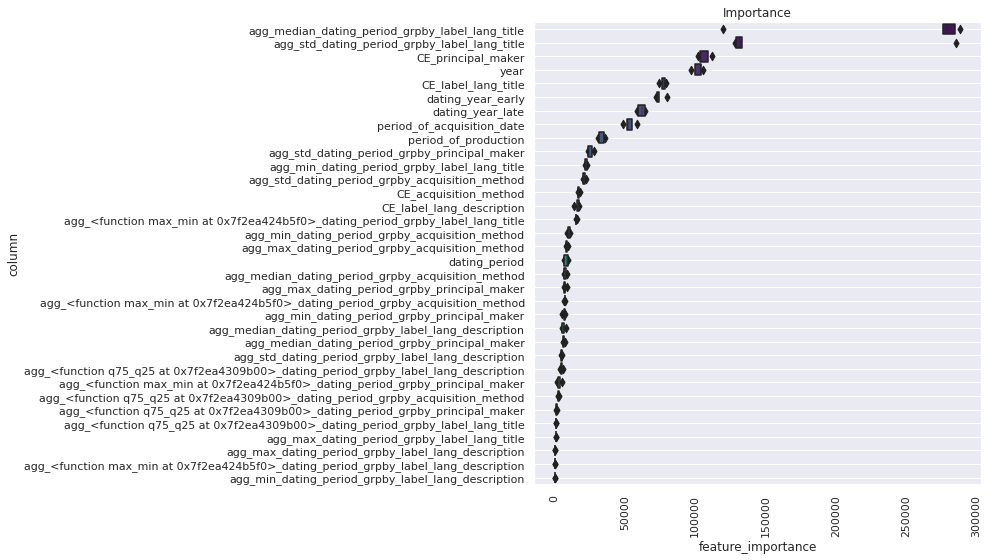

In [44]:
fig, _ = visualize_importance(models, feat_train_df=train_feat_df)

In [45]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

In [47]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })
sub_df.to_csv(os.path.join(OUTPT_PAHT, 'baseline.csv'), index=False)

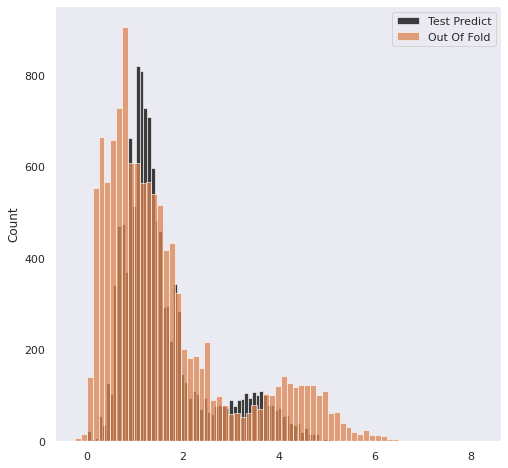

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()